In [1]:
import csv
import os
import re

import nltk
import numpy as np
import pandas as pd
from datetime import datetime
from nltk.tokenize import word_tokenize
from official.nlp import optimization
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
import tensorflow_text as text
import bert

In [3]:
# Include this block so that keras 
# # would not use up all the GPU memory.
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# # config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
OUTPUT_DIR = './model/'
datafiles_path = './data/drug_sentence_classification.csv'
data_files = pd.read_csv(datafiles_path)

In [6]:
data_files.head()

,neutral_citation,sentence_id,important,sentence
0,[2009] HKCFI 2104,0,False,"## HKSAR v. MWANIKI, CATHERINE WAITHIRA [2009..."
1,[2009] HKCFI 2104,1,False,HCCC241/2008
2,[2009] HKCFI 2104,2,False,IN THE HIGH COURT OF THE
3,[2009] HKCFI 2104,3,False,HONG KONG SPECIAL ADMINISTRATIVE REGION
4,[2009] HKCFI 2104,4,False,COURT OF FIRST INSTANCE


In [7]:
datas_X = data_files['sentence']
datas_Y = data_files['important'].astype(int)

In [8]:
datas_X.head()

0    ##  HKSAR v. MWANIKI, CATHERINE WAITHIRA [2009...
1                                         HCCC241/2008
2                             IN THE HIGH COURT OF THE
3              HONG KONG SPECIAL ADMINISTRATIVE REGION
4                              COURT OF FIRST INSTANCE
Name: sentence, dtype: object

In [9]:
datas_Y.head()

0    0
1    0
2    0
3    0
4    0
Name: important, dtype: int64

In [10]:
data_example = datas_X[0]
data_example

'##  HKSAR v. MWANIKI, CATHERINE WAITHIRA [2009] HKCFI 2104; HCCC 241/2008 (30\r\nMarch 2009)'

In [11]:
type(data_example)

str

In [12]:
#Clean up the data

#Function to clean up data
#•Only take characters inside A-Za-z
#•remove stop words
#•lemmatize

In [13]:
strip_special_chars = re.compile("[^A-Za-z0-9, ]+")

def cleanUpSentence(r):
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    words = word_tokenize(r)
    filtered_sentence = []
    for w in words:
        if any(map(str.isdigit, w)):
            filtered_sentence.append("0")
        elif w:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)

In [14]:
totalX = []
totalY = np.array(datas_Y).reshape((-1,1))
with tqdm(total=datas_X.shape[0], unit_scale=True) as pbar:
    for i, doc in enumerate(datas_X):
        #直接在这里去除\n，防止\n可能会让两句话连接处的两个单词连在一起
        doc = doc.replace("\n"," ")
        totalX.append(cleanUpSentence(doc))
        pbar.update()
totalX=np.array(totalX)

100%|██████████| 299k/299k [00:44<00:00, 6.67kit/s]  


In [15]:
empty_pred = data_files[totalX==''][['neutral_citation','sentence_id']]
empty_pred['important'] = [False] * empty_pred.shape[0]
empty_pred

,neutral_citation,sentence_id,important
6,[2009] HKCFI 2104,6,False
8,[2009] HKCFI 2104,8,False
41,[2009] HKCFI 2105,6,False
43,[2009] HKCFI 2105,8,False
77,[2009] HKCFI 2105,42,False
...,...,...,...
298676,[2012] HKCFI 1705,59,False
298686,[2012] HKCFI 795,6,False
298688,[2012] HKCFI 795,8,False
298690,[2012] HKCFI 795,10,False


In [16]:
totalX,totalY,total_idx = totalX[totalX!=''],totalY[totalX!=''],data_files[totalX!=''][['neutral_citation','sentence_id']]
totalX

array(['hksar v mwaniki , catherine waithira 0 hkcfi 0 hccc 0 0 march 0',
       '0', 'in the high court of the', ...,
       'in all the circumstances and bearing in mind the total amount of drugs involved and the principle of totality , i consider an overall sentence of 0 years to be appropriate',
       'to achieve that overall i sentence you to 0 years and 0 months imprisonment under charge 0 , and 0 years and 0 months imprisonment under charge 0 , and i order that 0 year and 0 months out of the 0 years and 0 months under charge 0 be served consecutively with the 0 years and 0 months under charge 0',
       'you will therefore go to prison for a total of 0 years'],
      dtype='<U1471')

In [17]:
total_idx

,neutral_citation,sentence_id
0,[2009] HKCFI 2104,0
1,[2009] HKCFI 2104,1
2,[2009] HKCFI 2104,2
3,[2009] HKCFI 2104,3
4,[2009] HKCFI 2104,4
...,...,...
298697,[2012] HKCFI 795,17
298698,[2012] HKCFI 795,18
298699,[2012] HKCFI 795,19
298700,[2012] HKCFI 795,20


In [18]:
xLengths = [len(word_tokenize(x)) for x in totalX]
# h = sorted(xLengths)  #sorted lengths 升序 第一个最小
# maxLength =h[len(h)-1]
maxLength = max(xLengths)
print("max input length is: ",maxLength)

max input length is:  267


In [19]:
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    #Zero Mask till seq_length
    zero_mask = [0] * (max_seq_len-len(tokens))
    input_ids.extend(zero_mask)
    input_mask.extend(zero_mask)
    segment_ids.extend(zero_mask)
    
    return input_ids, input_mask, segment_ids

def convert_all_sentences(sentences, tokenizer, max_seq_len=20):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    with tqdm(total=sentences.shape[0], unit_scale=True) as pbar:
        for sentence in sentences:
            input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
            all_input_ids.append(input_ids)
            all_input_mask.append(input_mask)
            all_segment_ids.append(segment_ids)
            pbar.update()
    return np.array(all_input_ids), np.array(all_input_mask), np.array(all_segment_ids)

In [20]:
VOCAB_FILE = 'small_bert_bert_en_uncased_L-8_H-512_A-8_1/assets/vocab.txt'

BertTokenizer = bert.bert_tokenization.FullTokenizer(VOCAB_FILE,do_lower_case=True)
input_ids, input_mask, segment_ids = convert_all_sentences(totalX, BertTokenizer, max_seq_len=maxLength)

100%|██████████| 266k/266k [01:22<00:00, 3.23kit/s] 


In [21]:
total_idx

,neutral_citation,sentence_id
0,[2009] HKCFI 2104,0
1,[2009] HKCFI 2104,1
2,[2009] HKCFI 2104,2
3,[2009] HKCFI 2104,3
4,[2009] HKCFI 2104,4
...,...,...
298697,[2012] HKCFI 795,17
298698,[2012] HKCFI 795,18
298699,[2012] HKCFI 795,19
298700,[2012] HKCFI 795,20


In [22]:
#Create Keras model
#num_categories 总标签数
num_categories = len(totalY[0])
num_categories
totalX.shape[0]

266137

In [23]:
DROPOUT = 0.1
MODEL_PATH = "./small_bert_bert_en_uncased_L-8_H-512_A-8_1"

def create_bert_classifier(max_seq_len):
    input_ids = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='input_ids')
    input_mask = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='input_mask')
    segment_ids = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='segment_ids')
    bert_inputs = dict(
        input_word_ids=input_ids,
        input_mask=input_mask,
        input_type_ids=segment_ids)
    bert_model = hub.KerasLayer(MODEL_PATH, name="bert", trainable=True)
    net = bert_model(bert_inputs)["pooled_output"]
    net = Dropout(DROPOUT, name="dropout")(net)
    net = Dense(num_categories, activation='sigmoid', name="logistic output")(net)
    return tf.keras.Model(inputs=[input_ids,input_mask,segment_ids], outputs=net)


In [24]:
%%capture train

kf = KFold(n_splits=5,shuffle=True)
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_PROPORTION = 0.1

num_train_steps = int(totalX.shape[0]*0.8 / BATCH_SIZE * EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

prediction = []
prediction_index = []
histories = []

loop = 0
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

for train_index, test_index in kf.split(totalX):
    trainX = {
        "input_ids": input_ids[train_index],
        "input_mask": input_mask[train_index],
        "segment_ids": segment_ids[train_index]
    }
    trainY = totalY[train_index]
    testX = {
        "input_ids": input_ids[test_index],
        "input_mask": input_mask[test_index],
        "segment_ids": segment_ids[test_index]
    }
    testY = totalY[test_index]
#     print(data_files.loc[total_idx.iloc[test_index].index][['neutral_citation','sentence_id']])
    
    with strategy.scope():
        model = create_bert_classifier(maxLength)
        optimizer = optimization.create_optimizer(init_lr=LEARNING_RATE,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
        
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])    
    
    histories.append(model.fit(trainX, 
                               trainY, 
                               validation_split=0.1, 
                               batch_size=BATCH_SIZE, 
                               epochs=EPOCHS))
    
    print(model.evaluate(testX, testY, batch_size=BATCH_SIZE))
    prediction_index.extend(data_files.loc[total_idx.iloc[test_index].index][['neutral_citation','sentence_id']].values.tolist())
    prediction.extend(model.predict(testX))
    
    saved_model_path = './model/{}_bert '.format(loop)+str(datetime.now())
    model.save(saved_model_path, include_optimizer=False, overwrite=True)
    loop+=1
    

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0', '/device:GPU:1')
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CollectiveCommunication.AUTO
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Collective batch_all_reduce: 136 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce for IndexedSlices: 1 all-reduces, group_size = 2
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_red

In [25]:
%%capture charts

import matplotlib.pyplot as plt


for history in histories:
    
    plt.figure()
    
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss,  label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plt.show()


In [26]:
import csv
with open('output/extracted_importance_bert.csv', 'w') as ofile:
    csv_writer = csv.writer(ofile, delimiter=',', quotechar='"')
    csv_writer.writerow(list(data_files.columns)[:-1])
    for idx, predict in zip(prediction_index, prediction):
        csv_writer.writerow(idx + list(predict>0.5))
empty_pred.to_csv('output/extracted_importance_bert.csv', mode='a', header=False, index=False)

In [29]:
train.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Collective batch_all_reduce: 136 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce for IndexedSlices: 1 all-reduces, group_size = 2
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
INFO:tensorflow:Collective batch_all_reduce: 1 all-redu

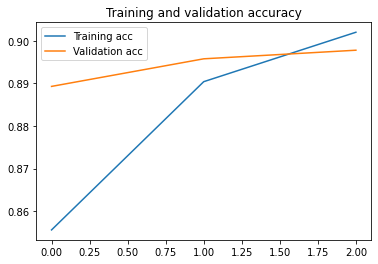

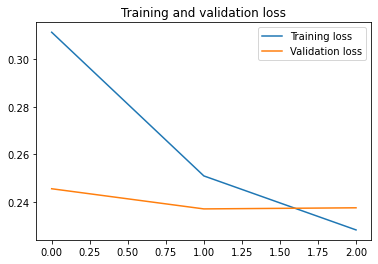

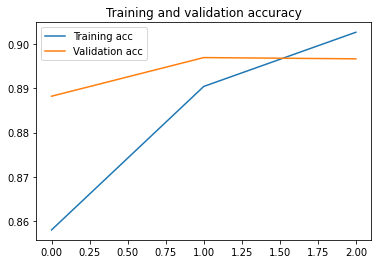

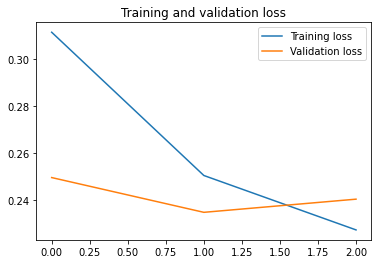

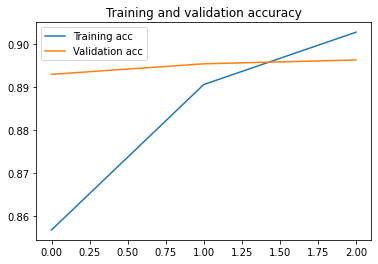

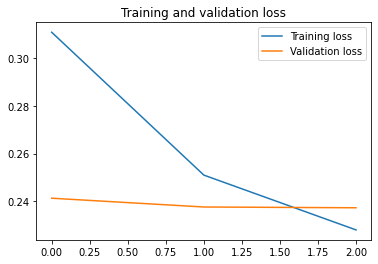

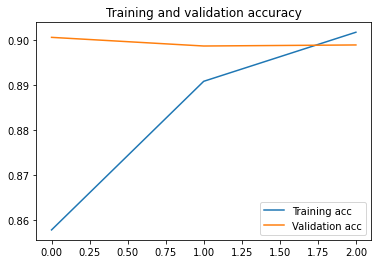

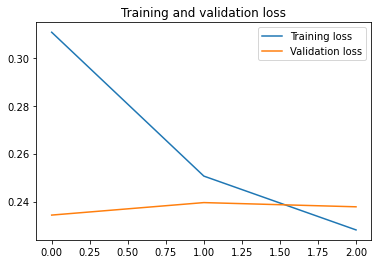

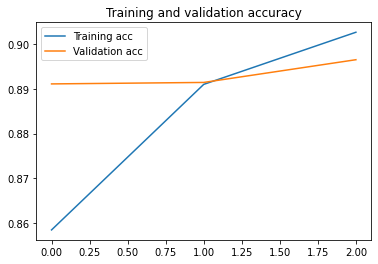

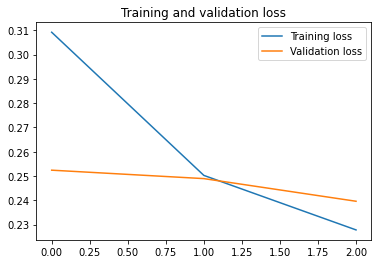

In [28]:
charts.show()

In [30]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 267)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 267)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 267)]        0                                            
__________________________________________________________________________________________________
bert (KerasLayer)               {'encoder_outputs':  41373185    input_mask[0][0]                 
                                                                 segment_ids[0][0]     